### Function definitions

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ipywidgets import widgets
from IPython.display import display

pdg_color_map = {
    12: 'gray',         # electron neutrino
    14: 'gray',         # muon neutrino
    16: 'gray',         # tau neutrino
    11: 'red',          # electron
    -11: 'red',         # positron
    13: 'magenta',      # muon
    -13: 'magenta',     # muon+
    15: 'violet',       # tau
    -15: 'violet',      # tau+
    2212: 'blue',       # proton
    2112: 'cyan',       # neutron
    211: 'orange',      # pi+
    -211: 'darkorange', # pi-
    111: 'gold',        # pi0
    321: 'green',       # K+
    -321: 'darkgreen',  # K-
    311: 'lime',        # K0
    22: 'yellow',       # photon
}

def visualize_particles_with_slider( # visualize particles at each time step
    positions_list, momenta_list, pdg_codes_list, 
    timestep_list=None,
    xlim=None, ylim=None, zlim=None
):
    n_steps = len(positions_list)

    # Create figure and axis once
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def plot_frame(step):
        ax.clear()
        positions = np.asarray(positions_list[step])
        momenta = np.asarray(momenta_list[step])
        pdg_codes = np.asarray(pdg_codes_list[step])

        for i in range(len(positions)):
            x, y, z = positions[i]
            px, py, pz = momenta[i]
            color = pdg_color_map.get(pdg_codes[i], 'black')

            # Draw momentum vector (arrow)
            ax.quiver(x, y, z, px, py, pz, length=1, normalize=True, 
                      arrow_length_ratio=0.1, color=color)
            # Draw particle position (marker)
            ax.scatter(x, y, z, color=color, marker='o', s=50)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if timestep_list:
            ax.set_title(f'Particle Visualization - Time Step {timestep_list[step]} ({len(pdg_codes)} particles)')
        else:
            ax.set_title(f'Particle Visualization - Time Step {step} ({len(pdg_codes)} particles)')


        # Apply fixed limits if provided
        if xlim:
            ax.set_xlim(*xlim)
        if ylim:
            ax.set_ylim(*ylim)
        if zlim:
            ax.set_zlim(*zlim)

        fig.canvas.draw_idle()  # Efficient redraw

    # Create and display the slider
    slider = widgets.IntSlider(
        min=0, max=n_steps - 1, step=1, value=0, description='Time Step'
    )

    def on_slider_change(change):
        if change['name'] == 'value':
            plot_frame(change['new'])

    slider.observe(on_slider_change)
    display(slider)

    # Initial plot
    plot_frame(0)

def visualize_particle_trajectories(particle_list, xlim=None, ylim=None, zlim=None, time_range=None, min_step=0):
    """
    Visualize 3D particle trajectories using connected lines.

    Parameters:
        particle_list: list of dicts with keys ['PDG', 'gen', 'positions', ...]
        xlim, ylim, zlim: optional (min, max) axis limits
        time_range: optional (start_ttt, end_ttt), inclusive range of time steps to show
        min_step: don't draw particles with number of time steps smaller than min_step
    """
    if isinstance(particle_list, dict):
        particle_list = [particle_list]

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    tmin_plot, tmax_plot = float("inf"), float("-inf")

    npar = 0
    for particle in particle_list:
        pdg = particle["PDG"]
        color = pdg_color_map.get(pdg, 'black')

        positions = particle["positions"]
        step_offset = particle["initial_step"]  # actual starting ttt
        n_steps = len(positions)

        # Time steps where this particle exists
        ttt_steps = list(range(step_offset, step_offset + n_steps))

        # Filter by time_range if provided
        if time_range is not None:
            tmin, tmax = time_range
            mask = [(tmin <= t <= tmax) for t in ttt_steps]
            if not any(mask):
                continue  # particle not active in time range
            positions = positions[mask]
            ttt_steps = [t for t, m in zip(ttt_steps, mask) if m]

        if len(positions) < min_step:
            continue  # skip particles with too few points

        xs, ys, zs = positions[:, 0], positions[:, 1], positions[:, 2]
        ax.plot(xs, ys, zs, color=color, marker='.', markersize=1, linewidth=1,
                label=f"PDG {pdg}, tstart {particle['initial_step']}")
        ax.scatter(xs[-1], ys[-1], zs[-1], color=color, marker='^', s=10)  # end
        npar += 1
        
        # Update global time range
        tmin_plot = min(tmin_plot, min(ttt_steps))
        tmax_plot = max(tmax_plot, max(ttt_steps))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Particle Trajectories in time step window [{tmin_plot}, {tmax_plot}] ({npar} particles)")

    if xlim: ax.set_xlim(*xlim)
    if ylim: ax.set_ylim(*ylim)
    if zlim: ax.set_zlim(*zlim)

    #ax.legend(loc="best", fontsize=8)
    plt.show()


# generate GIF
import matplotlib.animation as animation
from pathlib import Path

def save_particles_gif(
    positions_list, momenta_list, pdg_codes_list,
    timestep_list=None,
    xlim=None, ylim=None, zlim=None,
    step_range=None,  # e.g. [1, 152]
    filename="particle_evolution.gif",
    fps=5
):
    if step_range is None:
        step_range = (0, len(positions_list))

    start_step, end_step = step_range
    if start_step < 1:
        start_step = 1
    if end_step > len(positions_list):
        end_step = len(positions_list)
    Path(filename).parent.mkdir(parents=True, exist_ok=True)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    def plot_frame(step):
        ax.clear()
        positions = np.asarray(positions_list[step])
        momenta = np.asarray(momenta_list[step])
        pdg_codes = np.asarray(pdg_codes_list[step])

        for i in range(len(positions)):
            x, y, z = positions[i]
            px, py, pz = momenta[i]
            color = pdg_color_map.get(pdg_codes[i], 'black')
            ax.quiver(x, y, z, px, py, pz, length=1, normalize=True,
                      arrow_length_ratio=0.1, color=color)
            ax.scatter(x, y, z, color=color, marker='o', s=50)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        title = f"Particle Visualization - Time Step {timestep_list[step]}" if timestep_list else f"Step {step}"
        ax.set_title(f"{title} ({len(pdg_codes)} particles)")

        if xlim: ax.set_xlim(*xlim)
        if ylim: ax.set_ylim(*ylim)
        if zlim: ax.set_zlim(*zlim)

    def update(frame_idx):
        plot_frame(start_step-1 + frame_idx)
        return ax,

    ani = animation.FuncAnimation(
        fig, update, frames=(end_step+1 - start_step), blit=False
    )

    ani.save(filename, writer='pillow', fps=fps)
    plt.close(fig)
    print(f"[Saved] {filename} - time step [{start_step}, {end_step}]")


#### Create a eventID map (due to the current issue GiBUU does not preserve the event order)

In [2]:
### edit here the data directory
data_path = "/exp/dune/data/users/yinrui/GiBUU/test"

import uproot
#import glob
# Load ROOT files
#root_files = sorted(glob.glob(f"{data_path}/EventOutput.Pert.00000*.root"))

### Create an event ID map due to current order bug in GiBUU
eWID_arr = []
for ttt in range(1, 153, 1): # range(1, 153, 1)
    file_name = f"{data_path}/EventOutput.Pert.00000{ttt:03d}.root"
    with uproot.open(file_name) as file:
        tree = file["RootTuple"]
        eWID_arr.append(tree["weight"].array(library="np"))
eWID_arr = np.array(eWID_arr)
print(f"(n_time_steps, n_events) == {np.shape(eWID_arr)}")

# Assume eWID_arr is a (152, 19142) array
ref_eWID = eWID_arr[0]  # Shape: (19142,)

# Initialize the eventID map
eID_map = np.empty_like(eWID_arr, dtype=int)

for ttt in range(len(eWID_arr)):
    # Build map: for each value in ref_eWID, find where it appears in eWID_arr[ttt]
    # This assumes all values are present and unique

    # Get argsort to sort both arrays
    ref_sort = np.argsort(ref_eWID)
    ttt_sort = np.argsort(eWID_arr[ttt])

    # ref_sort[ii] is the event index in time step 0 at position ii in sorted list
    # ttt_sort[ii] is the event index in time step `ttt` at position ii in sorted list
    # So event i in time step 0 corresponds to index eID_map[ttt][i] in time step ttt
    inverse_map = np.empty_like(ref_sort)
    inverse_map[ref_sort] = ttt_sort

    eID_map[ttt] = inverse_map

    if (eWID_arr[ttt][inverse_map] != ref_eWID).any(): # make sure the weight value can be used as a unique ID for events
        print("[Warning] worth checking!")

(n_time_steps, n_events) == (152, 19142)


### Visualize the event (with index `event_idx`) at each time step

In [3]:
timestep_list = []
positions_list = []
momenta_list = []
PDG_list = []
particle_list = []
UID_list = []

### edit here the eventID to visualize 
event_idx = 1000
with uproot.open(f"{data_path}/EventOutput.Pert.00000001.root") as file:
    eWID = file["RootTuple"]["weight"].array(library="np")[event_idx]
    print(f"##### Event number {event_idx} (weightID {eWID})")
for ttt in range(1, 153, 1): # range(1, 153, 1)
    file_name = f"{data_path}/EventOutput.Pert.00000{ttt:03d}.root"
    timestep_list.append(ttt)
    with uproot.open(file_name) as file:
        tree = file["RootTuple"]
        #wid = tree["weight"].array(library="np")[event_idx]
        #if wid != eWID:
        #    print(f"[Warning] Step {ttt} has altered weightID {wid}")
        #eid = event_idx
        eid = eID_map[ttt-1, event_idx]
        
        x = tree["x"].array(library="np")[eid]
        y = tree["y"].array(library="np")[eid]
        z = tree["z"].array(library="np")[eid]
        px = tree["Px"].array(library="np")[eid]
        py = tree["Py"].array(library="np")[eid]
        pz = tree["Pz"].array(library="np")[eid]
        pdg = tree["barcode"].array(library="np")[eid]
        #ID = tree["ID"].array(library="np")[eid]
        #gen = tree["gen"].array(library="np")[eid]
        #parent1 = tree["parent1"].array(library="np")[eid]
        #parent2 = tree["parent2"].array(library="np")[eid]
        #parent3 = tree["parent3"].array(library="np")[eid]
        UID = tree["UID"].array(library="np")[eid]

        positions = np.stack([x, y, z], axis=1)
        momenta = np.stack([px, py, pz], axis=1)
        #parents = np.stack([parent1, parent2, parent3], axis=1)

        positions_list.append(positions)
        momenta_list.append(momenta)
        PDG_list.append(pdg)
        UID_list.append(UID)


##### Event number 1000 (weightID 0.00017496548875148418)


##### Event number 1000


IntSlider(value=0, description='Time Step', max=151)

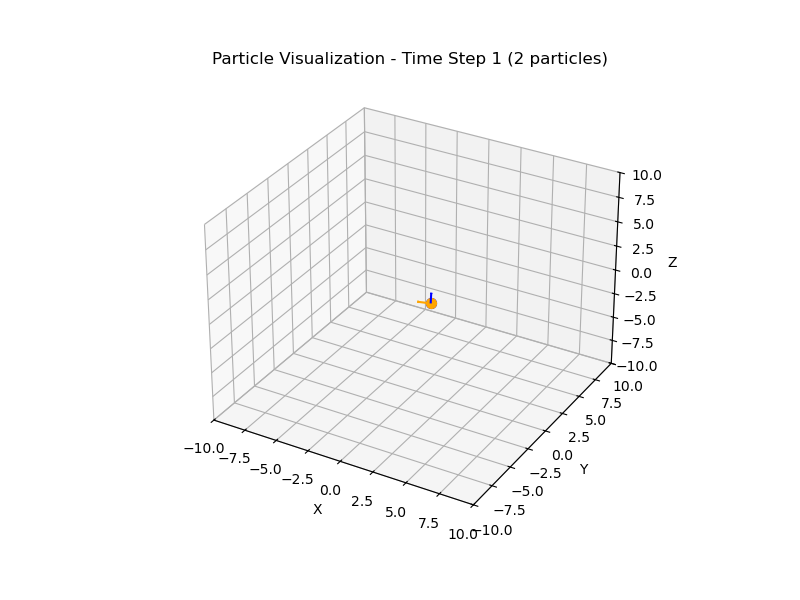

In [4]:
print(f"##### Event number {event_idx}")
#print(positions_list, momenta_list, PDG_list, sep="\n")
visualize_particles_with_slider(positions_list, momenta_list, PDG_list, timestep_list, xlim=[-10,10], ylim=[-10,10], zlim=[-10,10])

### Visualize particle trajectories in the event in `time_range`

In [5]:
from collections import defaultdict

particle_dict = {}  # UID → particle info
uid_time_map = defaultdict(list)  # UID → list of time step indices
duplicates_found = False

for step_idx, ttt in enumerate(timestep_list):
    positions = positions_list[step_idx]
    momenta = momenta_list[step_idx]
    pdgs = PDG_list[step_idx]

    file_name = f"{data_path}/EventOutput.Pert.00000{ttt:03d}.root"
    with uproot.open(file_name) as file:
        tree = file["RootTuple"]
        UID = UID_list[step_idx]

    seen_uids = set()
    for i in range(len(UID)):
        uid = int(UID[i])

        # Check duplicate UID in same step
        if uid in seen_uids:
            print(f"[Warning] Duplicate UID {uid} at time step {ttt} (index {step_idx})")
            duplicates_found = True
        seen_uids.add(uid)

        if uid not in particle_dict:
            particle_dict[uid] = {
                "PDG": int(pdgs[i]),
                "gen": uid,  # store UID in gen field as requested
                "initial_step": ttt,
                "positions": [],
                "momenta": [],
                "timesteps": []
            }

        particle_dict[uid]["positions"].append(positions[i])
        particle_dict[uid]["momenta"].append(momenta[i])
        particle_dict[uid]["timesteps"].append(ttt)
        uid_time_map[uid].append(ttt)

# Check for time gaps
for uid, steps in uid_time_map.items():
    sorted_steps = sorted(steps)
    gaps = [b - a for a, b in zip(sorted_steps, sorted_steps[1:])]
    if any(gap > 1 for gap in gaps):
        print(f"[Warning] UID {uid} has time step gap: {sorted_steps}")

# Final conversion to particle_list
particle_list = []
for uid, p in particle_dict.items():
    particle_list.append({
        "PDG": p["PDG"],
        "gen": p["gen"],  # this is actually UID
        "initial_step": p["initial_step"],
        "positions": np.array(p["positions"]),
        "momenta":  np.array(p["momenta"]),
    })


##### Event number 1000 (12 particles in total)


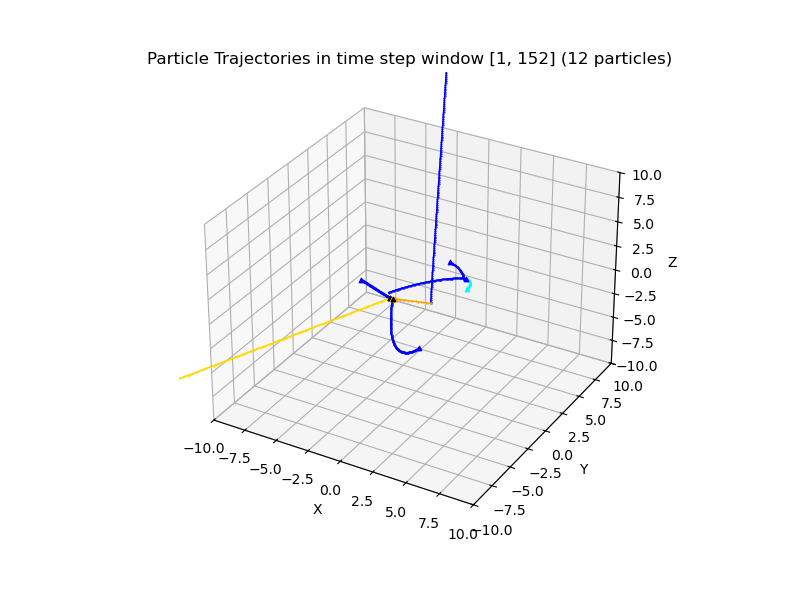

In [6]:
print(f"##### Event number {event_idx} ({len(particle_list)} particles in total)")
#print(*[{"PDG": p["PDG"], "gen": p["gen"], "initial_step": p["initial_step"]} for p in particle_list], sep="\n")
visualize_particle_trajectories(particle_list, time_range=[0,154], xlim=[-10,10], ylim=[-10,10], zlim=[-10,10])

### Generate a GIF animation

In [7]:
save_particles_gif(
    positions_list, momenta_list, PDG_list,
    timestep_list=timestep_list,
    xlim=[-10, 10], ylim=[-10, 10], zlim=[-10, 10],
    step_range=(1, 160),
    filename="plots/particles.gif",
    fps=5
)

[Saved] plots/particles.gif - time step [1, 152]


### Save data to hdf5

In [8]:
### need to run the first two cells
positions_list_all = [[] for _ in range(len(eID_map[0]))]
momenta_list_all = [[] for _ in range(len(eID_map[0]))]
PDG_list_all = [[] for _ in range(len(eID_map[0]))]
UID_list_all = [[] for _ in range(len(eID_map[0]))]

timestep_list = list(range(1, 153))
n_events = len(eID_map[0])

for step_idx, ttt in enumerate(timestep_list):
    file_name = f"{data_path}/EventOutput.Pert.00000{ttt:03d}.root"
    with uproot.open(file_name) as file:
        tree = file["RootTuple"]

        x_all = tree["x"].array(library="np")
        y_all = tree["y"].array(library="np")
        z_all = tree["z"].array(library="np")
        px_all = tree["Px"].array(library="np")
        py_all = tree["Py"].array(library="np")
        pz_all = tree["Pz"].array(library="np")
        pdg_all = tree["barcode"].array(library="np")
        UID_all = tree["UID"].array(library="np")

    for event_idx in range(n_events):
        eid = eID_map[step_idx, event_idx]

        x = x_all[eid]
        y = y_all[eid]
        z = z_all[eid]
        px = px_all[eid]
        py = py_all[eid]
        pz = pz_all[eid]
        pdg = pdg_all[eid]
        UID = UID_all[eid]

        positions = np.stack([x, y, z], axis=1)
        momenta = np.stack([px, py, pz], axis=1)

        positions_list_all[event_idx].append(positions)
        momenta_list_all[event_idx].append(momenta)
        PDG_list_all[event_idx].append(pdg)
        UID_list_all[event_idx].append(UID)

    if (step_idx + 1) % 10 == 0:
        print(f"### Loaded step {step_idx+1}/{len(timestep_list)}")


### Loaded step 10/152
### Loaded step 20/152
### Loaded step 30/152
### Loaded step 40/152
### Loaded step 50/152
### Loaded step 60/152
### Loaded step 70/152
### Loaded step 80/152
### Loaded step 90/152
### Loaded step 100/152
### Loaded step 110/152
### Loaded step 120/152
### Loaded step 130/152
### Loaded step 140/152
### Loaded step 150/152


In [9]:
import h5py

with h5py.File("output_particles.h5", "w") as f:
    for event_idx, (positions_list, momenta_list, PDG_list, UID_list) in enumerate(zip(
        positions_list_all, momenta_list_all, PDG_list_all, UID_list_all
    )):
        group = f.create_group(f"event_{event_idx}")

        particle_records = []
        num_particles = []

        for step_idx, ttt in enumerate(timestep_list):
            positions = positions_list[step_idx]
            momenta = momenta_list[step_idx]
            pdgs = PDG_list[step_idx]
            uids = UID_list[step_idx]

            n_particles = len(uids)
            num_particles.append(n_particles)

            for i in range(n_particles):
                record = (
                    ttt, int(uids[i]),
                    *positions[i],
                    *momenta[i],
                    int(pdgs[i])
                )
                particle_records.append(record)

        particle_records = np.array(particle_records, dtype=[
            ('time_step', 'i4'),
            ('uid', 'i8'),
            ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
            ('px', 'f4'), ('py', 'f4'), ('pz', 'f4'),
            ('PDG', 'i4')
        ])

        group.create_dataset("particles", data=particle_records)
        group.create_dataset("num_particles_per_step", data=np.array(num_particles, dtype='i4'))


In [10]:
### top-level keys: event_0, event_1, ...
with h5py.File('output_particles.h5', 'r') as f:
    print("First five top-level keys:")
    nkeys = 0
    for key in f:
        print(f"  {key}")
        nkeys += 1
        if nkeys > 5:
            break
print()

### contents in each event
ievt = 0
with h5py.File('output_particles.h5', 'r') as f:
    grp = f[f'event_{ievt}']
    print(f"Contents of event_{ievt}:")
    for name in grp:
        obj = grp[name]
        print(f"  {name}: shape={obj.shape}, dtype={obj.dtype}")
print()

### particles.dtype.names ('time_step', 'uid', 'x', 'y', 'z', 'px', 'py', 'pz', 'PDG')
with h5py.File('output_particles.h5', 'r') as f:
    particles = f[f'event_{ievt}/particles']
    print("First 5 rows:")
    print(particles[:5])
print()

### auxiliary dataset
with h5py.File('output_particles.h5', 'r') as f:
    n_particles = f[f'event_{ievt}/num_particles_per_step'][:]
    print("Particles per step:", n_particles)
print()

First five top-level keys:
  event_0
  event_1
  event_10
  event_100
  event_1000
  event_10000

Contents of event_0:
  num_particles_per_step: shape=(152,), dtype=int32
  particles: shape=(835,), dtype=[('time_step', '<i4'), ('uid', '<i8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('px', '<f4'), ('py', '<f4'), ('pz', '<f4'), ('PDG', '<i4')]

First 5 rows:
[(1, 100438, 2.0931642, -2.7057195, 0.2997023, -0.66604334,  1.024618  , 1.400406 , 2112)
 (1, 100439, 2.0931642, -2.7057195, 0.2997023, -0.05910364, -0.32833585, 0.4430661, 2212)
 (2, 100438, 2.0931642, -2.7057195, 0.2997023, -0.66604334,  1.024618  , 1.400406 , 2112)
 (2, 100439, 2.0931642, -2.7057195, 0.2997023, -0.05910364, -0.32833585, 0.4430661, 2212)
 (3, 100438, 2.0289752, -2.6069424, 0.434838 , -0.66438544,  1.0225568 , 1.4006779, 2112)]

Particles per step: [2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 